In [9]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# 回测框架
import backtrader as bt

# 基础函数
import utilsJ

# 策略

### 买入信号

波浪均线出现向上拐头（前两日均下降，今日上升）且当日收盘价在布林带中线之上。

### 买入仓位

根据海龟ATR仓位计算最优仓位。

### 卖出信号

波浪均线出现向下拐头（前两日均上升，今日下降）或收盘价向下突破布林带上界。

### 卖出仓位

一律平仓。


In [26]:
class BW_sing(bt.Strategy):
    
    params = (
        # General params
        ('printlog', False),
        ('units', 1),
        ('p_stake', 100),

        # Indicator params
        ('bollinger_per', 20),
        ('bollinger_dev', 2),
        ('direction_lag', 5),
        ('wave_period', 7),
        
        # ATR params
        ('using_atr', False),
        ('atr_period', 14),
        ('atr_percent', 1),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        # Keep references to lines in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low

        # Keep references to executed order & price
        self.buyprice = 0
        self.sellprice = 0
        self.order = None

        # Add indicators
        ## Bollinger Bands indicator
        self.bolling = bt.indicators.BollingerBands(self.datas[0], 
                                                    period = self.params.bollinger_per, 
                                                    devfactor = self.params.bollinger_dev)
        #self.direction = self.bolling.mid(0) > self.bolling.mid(-self.params.direction_lag)
        self.direction = bt.And(self.dataclose(0) > self.dataclose(-1), 
                                                 self.dataclose(-1) > self.dataclose(-2), 
                                                 self.dataclose(-2) > self.dataclose(-3))
        #self.bolling_buy = bt.Or(bt.And(self.dataclose(0) > self.bolling.top(0), self.dataclose(-1) < self.bolling.top(-1)), 
        #                         bt.And(self.dataclose(0) > self.bolling.bot(0), self.dataclose(-1) < self.bolling.bot(-1)))
        self.bolling_buy = bt.And(self.dataclose(-1) < self.bolling.mid(-1), self.dataclose(0) > self.bolling.mid(0))
        self.bolling_sell = bt.Or(bt.And(self.dataclose(0) < self.bolling.top(0), self.dataclose(-1) > self.bolling.top(-1)), 
                                  bt.And(self.dataclose(0) < self.bolling.bot(0), self.dataclose(-1) > self.bolling.bot(-1)))

        ## ATR indicator
        self.atr_initial = self.broker.get_cash()
        self.tr = bt.indicators.Max((self.datahigh - self.datalow), 
                                    abs(self.dataclose(-1) - self.datahigh),
                                    abs(self.dataclose(-1) - self.datalow))
        self.atr = bt.indicators.SimpleMovingAverage(self.tr, period=self.params.atr_period)

        ## Wave indicator
        ### MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.wave_period)
        #self.wave_buy = bt.Or(bt.And(self.sma(0) > self.sma(-1), self.sma(-1) < self.sma(-2), self.sma(-2) < self.sma(-3)),
        #                                        bt.And(self.sma(0) > self.sma(-1), self.sma(-1) > self.sma(-2), self.sma(-2) > self.sma(-3), 
        #                                                     self.dataclose(0) < self.bolling.top(0), self.dataclose(-1) < self.bolling.top(-1), self.dataclose(-2) < self.bolling.top(-2)))
        self.wave_buy = bt.And(self.sma(0) > self.sma(-1), self.sma(-1) < self.sma(-2), self.sma(-2) < self.sma(-3), self.sma(0) > self.bolling.mid(0))
        self.wave_sell = bt.And(self.sma(0) < self.sma(-1), self.sma(-1) > self.sma(-2), self.sma(-2) > self.sma(-3))

        self.money_unit = self.broker.get_cash() / self.params.units


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.log('BUY EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                         (order.executed.price,
                          order.executed.size,
                          self.broker.get_cash()))

            else:  # Sell
                self.sellprice = order.executed.price
                self.log('SELL EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                        (order.executed.price,
                          -order.executed.size,
                          self.broker.get_cash()))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        #self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        self.money_unit = self.broker.get_cash() / self.params.units

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        buy_indicator = (self.wave_buy and self.dataclose[0] > self.bolling.mid[0]) or self.bolling_buy
        # buy_indicator = self.wave_buy and self.dataclose[0] > self.bolling.mid[0]
        sell_indicator = self.bolling_sell or self.wave_sell
            
        if buy_indicator and self.getposition(self.data).size == 0 and self.direction:
            if self.params.using_atr:
                opt_pos = np.round(self.atr_initial * self.params.atr_percent / self.params.p_stake / self.atr[0])
                if opt_pos*self.params.p_stake > 0 and self.getposition(self.data).size < opt_pos*self.params.p_stake:
                    self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                             (self.dataclose[0], 
                             opt_pos*self.params.p_stake-self.getposition(self.data).size,
                             self.getposition(self.data).size))
                    self.buy(size=opt_pos*self.params.p_stake-self.getposition(self.data).size)
            else:
                lots = np.floor(self.money_unit / (self.params.p_stake*self.dataclose[0]))*self.params.p_stake
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                        lots,
                        self.getposition(self.data).size))
                self.buy(size=lots)
        elif sell_indicator and self.getposition(self.data).size > 0:
            self.log('Sell CREATE(Close), Price: %.2f, Current Position: %i' % (self.dataclose[0],
                        self.getposition(self.data).size))
            self.close()


    def stop(self):
        self.log('Ending Position:%i. Ending Value:%.2f.' %
                (self.getposition(self.data).size,
                self.cerebro.broker.getvalue()), doprint=False)

### 沪深300回测调参-Bolling Dev

In [22]:
s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
e_date = datetime.date(2020,12,31)
idx = '399300.SZ'
pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
index_list = np.unique(pro.index_weight(index_code=idx,
                                        start_date=s_date.strftime('%Y%m%d'),
                                        end_date=e_date.strftime('%Y%m%d')).con_code).tolist()


profit_stk = dict()
for stk in index_list:
    max_profit = (0,0.0,0)
    for i in range(3,7):
        for j in np.arange(1.5,3,0.1):
            # Create a cerebro entity
            cerebro = bt.Cerebro()

            # Add a strategy
            strats = cerebro.addstrategy(BW_sing, printlog=False, direction_lag=i, bollinger_dev=float(j)) 

            # Create stock Data Feed
            #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
            #                    stock_index, s_date, e_date)
            df = pd.read_csv('.\\Data\\2019\\'+stk+'.csv', 
                                converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
            data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

            # Add the index Data Feed to Cerebo
            cerebro.adddata(data)

            # Set cash inside the strategy
            cerebro.broker = bt.brokers.BackBroker(coc=True)   
            cerebro.broker.setcash(300000)

            # Set commission
            #cerebro.broker.setcommission()

            # Print out the starting conditions
            start_value = cerebro.broker.getvalue()
            #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

            # Run over everything
            cerebro.run()

            # Print out the final result
            final_value = cerebro.broker.getvalue()
            #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
            print('%s, (%i, %.1f) Net Profit: %.2f%%' % (stk,i,j,(final_value - start_value) / start_value * 100))
            if max_profit[2] <  (final_value-start_value)/start_value*100:
                max_profit = (i,j,(final_value-start_value)/start_value*100)
    profit_stk[stk] = (final_value - start_value) / start_value * 100

000001.SZ, (3, 1.5) Net Profit: 31.54%
000001.SZ, (3, 1.6) Net Profit: 20.19%
000001.SZ, (3, 1.7) Net Profit: 18.57%
000001.SZ, (3, 1.8) Net Profit: 18.57%
000001.SZ, (3, 1.9) Net Profit: 40.45%
000001.SZ, (3, 2.0) Net Profit: 40.45%
000001.SZ, (3, 2.1) Net Profit: 42.66%
000001.SZ, (3, 2.2) Net Profit: 43.17%
000001.SZ, (3, 2.3) Net Profit: 39.32%
000001.SZ, (3, 2.4) Net Profit: 41.34%
000001.SZ, (3, 2.5) Net Profit: 41.34%
000001.SZ, (3, 2.6) Net Profit: 31.72%
000001.SZ, (3, 2.7) Net Profit: 31.25%
000001.SZ, (3, 2.8) Net Profit: 36.80%
000001.SZ, (3, 2.9) Net Profit: 33.63%
000001.SZ, (4, 1.5) Net Profit: 31.54%


KeyboardInterrupt: 

# 单股回测

In [27]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(BW_sing, printlog=True, direction_lag=20) 

    s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
    e_date = datetime.date(2020,12,31)

    # Create stock Data Feed
    stock_index = '000166.SZ'
    #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
    #                    stock_index, s_date, e_date)
    df = pd.read_csv('.\\Data\\2019\\' + stock_index + '.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)

    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(50000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

Starting Portfolio Value: 50000.00
2020-03-04: BUY CREATE, Price: 4.92, Lots: 10100, Current Position: 0
2020-03-05: BUY EXECUTED, Price:4.92, Lot:10100, Cash:308.
2020-03-09: Sell CREATE(Close), Price: 4.79, Current Position: 10100
2020-03-10: SELL EXECUTED, Price:4.79, Lot:10100, Cash:48687.
2020-03-10: OPERATION PROFIT, GROSS -1313.00, NET -1313.00
2020-05-06: BUY CREATE, Price: 4.44, Lots: 10900, Current Position: 0
2020-05-07: BUY EXECUTED, Price:4.44, Lot:10900, Cash:290.
2020-06-10: Sell CREATE(Close), Price: 4.45, Current Position: 10900
2020-06-11: SELL EXECUTED, Price:4.45, Lot:10900, Cash:48796.
2020-06-11: OPERATION PROFIT, GROSS 109.00, NET 109.00
2020-06-18: BUY CREATE, Price: 4.46, Lots: 10900, Current Position: 0
2020-06-19: BUY EXECUTED, Price:4.46, Lot:10900, Cash:182.
2020-06-29: Sell CREATE(Close), Price: 4.81, Current Position: 10900
2020-06-30: SELL EXECUTED, Price:4.81, Lot:10900, Cash:52610.
2020-06-30: OPERATION PROFIT, GROSS 3815.00, NET 3815.00
2020-08-17: BU

<IPython.core.display.Javascript object>


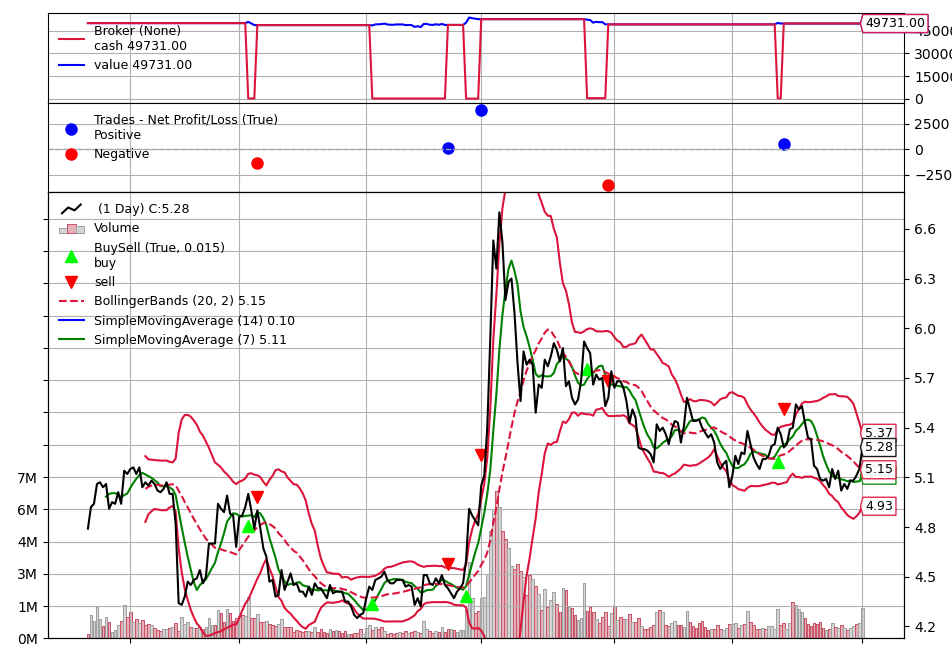

[[<Figure size 640x480 with 4 Axes>]]

In [28]:
cerebro.plot()